### Selection criteria
type: small molecule  
group: approved  
category: "Kinase Inhibitor" or "Protein Kinase Inhibitor"

In [86]:
import untangle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Parsing Drugbank XML

In [2]:
#takes 5 minutes
filename = "drugbank_20180402.xml" # DrugBank Version 5.1.0 (release date: 2018.04.20) 
obj = untangle.parse(filename)

### Building a dataframe to organize kinase inhibitor data

In [138]:
#Data Frame of DrugBank Small Molecule Type Drugs
df_drugbank_ki = pd.DataFrame(columns=["drugbank_id","name","min dosage strength value", 
                                       "max dosage strength value", "dosage strength unit", 
                                       "route", "form", "category","group","cas","smiles",
                                       "ALOGPS solubility value", "ALOGPS solubility unit"])
df_drugbank_ki

,drugbank_id,name,min dosage strength value,max dosage strength value,dosage strength unit,route,form,category,group,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit


In [139]:
# Takes around 10 minutes to run.
i=-1
#iterate over drug entries to extract information
for drug in obj.drugbank.drug:
    
    #print(drug)
    drug_type = str(drug["type"])
    
    # select for small molecule drugs
    if drug_type in ["small molecule", "Small Molecule", "Small molecule"]:
        i=i+1
        #print(drug.name.cdata, id.cdata)
        
        # Select drugs that are in approved group
        
        drug_groups = []
        for group in drug.groups.group:
            group_label = group.cdata
            drug_groups.append(group_label) 
        

        # If drug does not belong to "approved" group skip
        if "approved" not in  drug_groups:
            continue
        
        
        # Select drugs that belong to kinase inibitor drug category
        
        # Check if category information is available, skip if not
        if len(drug.categories) == 0:
            continue
            
        # Collect all category labels in a set
        category_set = set()
        
        for category in drug.categories.category:
            category_label = category.category.cdata
            #print(category_label)
            category_set.add(category_label)
            
        drug_category = []
        # Record this drug to database if it belongs to "Kinase Inhibitor" category
        if "Kinase Inhibitor" in category_set:
            drug_category.append("Kinase Inhibitor")
        if "Protein Kinase Inhibitors" in category_set:
            drug_category.append("Protein Kinase Inhibitor")
            
        if len(drug_category) >= 1:  # This is a kinase inhibitor
            
            #Drug category
            df_drugbank_ki.loc[i, "category"] = drug_category

            #Get drugbank_id
            for id in drug.drugbank_id:
                if str(id["primary"])=="true":
                    df_drugbank_ki.loc[i, "drugbank_id"]=id.cdata
            
            #Drug name
            df_drugbank_ki.loc[i,"name"]=drug.name.cdata

            #Drug CAS
            df_drugbank_ki.loc[i, "cas"]=drug.cas_number.cdata
            
            # Drug group    
            df_drugbank_ki.loc[i, "group"] = drug_groups

            #Get SMILES, logP, Solubility
            #Skip drugs with no structure. ("DB00386","DB00407","DB00702","DB00785","DB00840",
            #                                            "DB00893","DB00930","DB00965", "DB01109","DB01266",
            #                                           "DB01323", "DB01341"...)
            if len(drug.calculated_properties.cdata)==0: #If there is no calculated properties
                continue
            else:
                for property in drug.calculated_properties.property:
                    if property.kind.cdata == "SMILES":
                        df_drugbank_ki.loc[i, "smiles"]=property.value.cdata
        
                    if property.kind.cdata == "Water Solubility":
                        solubility_value, solubility_unit = property.value.cdata.split(" ") 
                        df_drugbank_ki.loc[i, "ALOGPS solubility value"] = float(solubility_value)
                        df_drugbank_ki.loc[i, "ALOGPS solubility unit"] = solubility_unit
                    
            # Dosage strength 
            
            # Check if there is any product data and skip otherwise
            if len(drug.products) == 0:
                continue
            
            # Save dosage information of all products in df_strength
            df_strength = pd.DataFrame(columns=["value", "unit", "route", "form"])
            
            for p_i, product in enumerate(drug.products.product):
                
                # check if strength information is available and skip otherwise 
                if len(product.strength.cdata) == 0:
                    continue
                
                # split the value and unit of dosage strength
                strength_value, strength_unit = product.strength.cdata.split(" ")
                df_strength.loc[p_i, "value"] = float(strength_value)
                df_strength.loc[p_i, "unit"] = strength_unit
                df_strength.loc[p_i, "form"] = product.dosage_form.cdata
                df_strength.loc[p_i, "route"] = product.route.cdata
                
            # Sort df_strength based on value column, ascending
            df_strength_sorted = df_strength.sort_values("value")
            df_strength_sorted= df_strength_sorted.reset_index(drop=True)
    
            # Save the info related to the minimum dosage strength to df_drugbank_ki
            df_drugbank_ki.loc[i, "min dosage strength value"] = df_strength_sorted.loc[0, "value"]
            df_drugbank_ki.loc[i, "dosage strength unit"] = df_strength_sorted.loc[0, "unit"]
            df_drugbank_ki.loc[i, "route"] = df_strength_sorted.loc[0, "route"]
            df_drugbank_ki.loc[i, "form"] = df_strength_sorted.loc[0, "form"] 
            
            # Sort df_strength based on value column, descending
            df_strength_sorted = df_strength.sort_values("value", ascending=False)
            df_strength_sorted= df_strength_sorted.reset_index(drop=True)
            
            # Save the info related to the max dosage strength to df_drugbank_ki
            df_drugbank_ki.loc[i, "max dosage strength value"] = df_strength_sorted.loc[0, "value"]

       # if i == 500:
       #     break

df_drugbank_ki = df_drugbank_ki.reset_index(drop=True)

In [140]:
print(df_drugbank_ki.shape)
df_drugbank_ki

(41, 13)


,drugbank_id,name,min dosage strength value,max dosage strength value,dosage strength unit,route,form,category,group,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB00317,Gefitinib,250,250,mg,Oral,Tablet,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",184475-35-2,COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)...,0.027,g/l
1,DB00398,Sorafenib,200,200,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",284461-73-0,CNC(=O)C1=NC=CC(OC2=CC=C(NC(=O)NC3=CC(=C(Cl)C=...,0.00171,g/l
2,DB00530,Erlotinib,25,150,mg,Oral,Tablet,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",183321-74-6,COCCOC1=C(OCCOC)C=C2C(NC3=CC=CC(=C3)C#C)=NC=NC...,0.00891,g/l
3,DB00619,Imatinib,50,400,mg,Oral,Capsule,"[Kinase Inhibitor, Protein Kinase Inhibitor]",[approved],152459-95-5,CN1CCN(CC2=CC=C(C=C2)C(=O)NC2=CC(NC3=NC=CC(=N3...,0.0146,g/l
4,DB00877,Sirolimus,0.5,5,mg,Oral,"Tablet, coated",[Kinase Inhibitor],"[approved, investigational]",53123-88-9,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,0.00173,g/l
5,DB01254,Dasatinib,20,140,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",302962-49-8,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(C)C=CC=C2Cl)=CC(...,0.0128,g/l
6,DB01259,Lapatinib,250,250,mg/1,Oral,Tablet,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",231277-92-2,CS(=O)(=O)CCNCC1=CC=C(O1)C1=CC2=C(C=C1)N=CN=C2...,0.0223,g/l
7,DB01268,Sunitinib,12.5,50,mg/1,Oral,Capsule,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",557795-19-4,CCN(CC)CCNC(=O)C1=C(C)NC(\C=C2/C(=O)NC3=C2C=C(...,0.0308,g/l
8,DB01590,Everolimus,0.25,10,mg/1,Oral,Tablet,[Kinase Inhibitor],[approved],159351-69-6,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,0.00163,g/l
9,DB04868,Nilotinib,50,200,mg/1,Oral,Capsule,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",641571-10-0,CC1=CN(C=N1)C1=CC(=CC(NC(=O)C2=CC(NC3=NC=CC(=N...,0.00201,g/l


In [141]:
# Save dataframe to csv
df_drugbank_ki.to_csv("dosage_strength_of_approved_kinase_inhibitors.csv")

In [142]:
df_drugbank_ki_sorted

,drugbank_id,name,min dosage strength value,max dosage strength value,dosage strength unit,route,form,category,group,cas,smiles,ALOGPS solubility value,ALOGPS solubility unit
0,DB01590,Everolimus,0.25,10,mg/1,Oral,Tablet,[Kinase Inhibitor],[approved],159351-69-6,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,1.63e-03,g/l
1,DB01590,Everolimus,0.25,10,mg/1,Oral,Tablet,[Kinase Inhibitor],[approved],159351-69-6,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,0.00163,g/l
2,DB08911,Trametinib,0.5,2,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]",[approved],871700-17-3,CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC...,0.0307,g/l
3,DB00877,Sirolimus,0.5,5,mg,Oral,"Tablet, coated",[Kinase Inhibitor],"[approved, investigational]",53123-88-9,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,1.73e-03,g/l
4,DB08911,Trametinib,0.5,2,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]",[approved],871700-17-3,CN1C(=O)C(C)=C2N(C(=O)N(C3CC3)C(=O)C2=C1NC1=CC...,3.07e-02,g/l
5,DB00877,Sirolimus,0.5,5,mg,Oral,"Tablet, coated",[Kinase Inhibitor],"[approved, investigational]",53123-88-9,[H][C@@]1(C[C@@H](C)[C@]2([H])CC(=O)[C@H](C)\C...,0.00173,g/l
6,DB06626,Axitinib,1,7,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",319460-85-0,[H]\C(=C(\[H])C1=CC=CC=N1)C1=C2C=CC(SC3=CC=CC=...,0.000511,g/l
7,DB06626,Axitinib,1,7,mg,Oral,"Tablet, film coated","[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",319460-85-0,[H]\C(=C(\[H])C1=CC=CC=N1)C1=C2C=CC(SC3=CC=CC=...,5.11e-04,g/l
8,DB09078,Lenvatinib,4,24,mg/1,Oral,Capsule,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",417716-92-8,COC1=C(C=C2C(OC3=CC(Cl)=C(NC(O)=NC4CC4)C=C3)=C...,0.0177,g/l
9,DB09078,Lenvatinib,4,24,mg/1,Oral,Capsule,"[Kinase Inhibitor, Protein Kinase Inhibitor]","[approved, investigational]",417716-92-8,COC1=C(C=C2C(OC3=CC(Cl)=C(NC(O)=NC4CC4)C=C3)=C...,1.77e-02,g/l


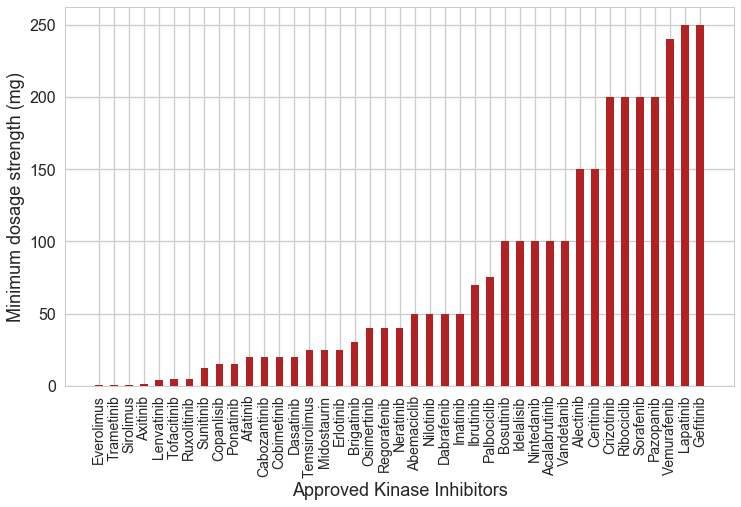

In [143]:
df_drugbank_ki_sorted = df_drugbank_ki.sort_values("min dosage strength value",ascending=True)
df_drugbank_ki_sorted = df_drugbank_ki_sorted.reset_index(drop=True)

x = df_drugbank_ki_sorted.index
names = df_drugbank_ki_sorted["name"]
min_dosage = df_drugbank_ki_sorted["min dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.5
plt.bar(x, min_dosage, width, color = "firebrick")
plt.xticks(x, names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Minimum dosage strength (mg)")
plt.tight_layout()

plt.savefig("min_dosage_strength_barplot_for_approved_kinase_inhibitors.pdf")

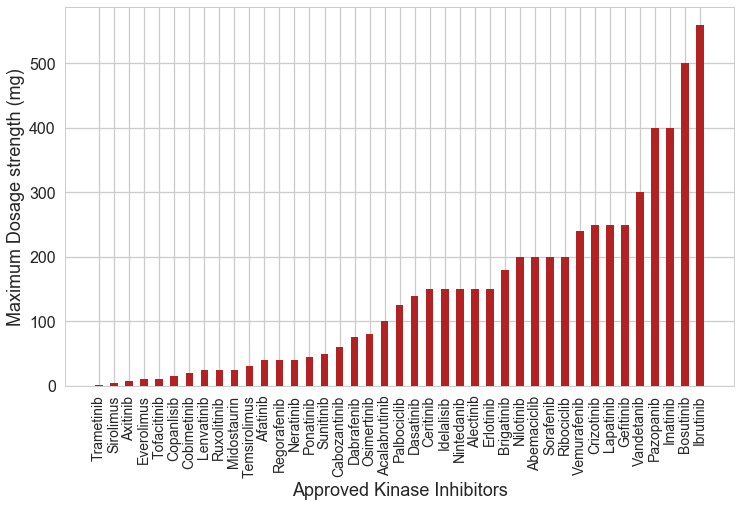

In [144]:
df_drugbank_ki_sorted = df_drugbank_ki.sort_values("max dosage strength value",ascending=True)
df_drugbank_ki_sorted = df_drugbank_ki_sorted.reset_index(drop=True)

x = df_drugbank_ki_sorted.index
names = df_drugbank_ki_sorted["name"]

max_dosage = df_drugbank_ki_sorted["max dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.5   
plt.bar(x, max_dosage, width, color = "firebrick")
plt.xticks(x, names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Maximum Dosage strength (mg)")
plt.tight_layout()

plt.savefig("max_dosage_strength_barplot_for_approved_kinase_inhibitors.pdf")

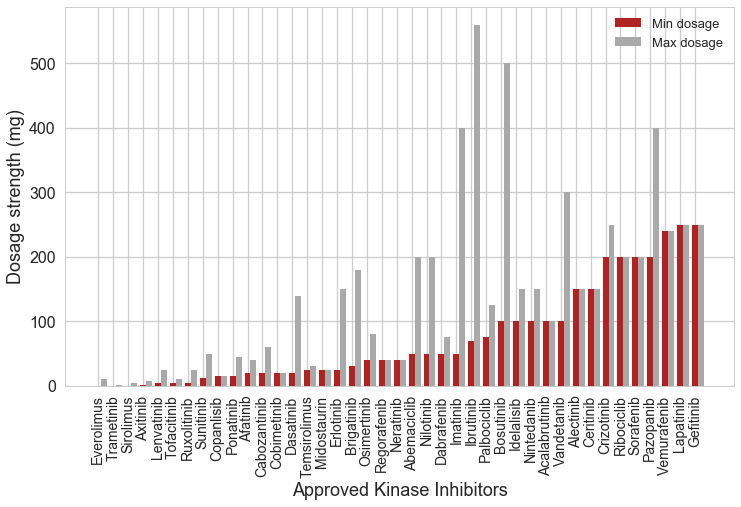

In [145]:
df_drugbank_ki_sorted = df_drugbank_ki.sort_values("min dosage strength value",ascending=True)
df_drugbank_ki_sorted = df_drugbank_ki_sorted.reset_index(drop=True)

x = df_drugbank_ki_sorted.index
names = df_drugbank_ki_sorted["name"]
min_dosage = df_drugbank_ki_sorted["min dosage strength value"]
max_dosage = df_drugbank_ki_sorted["max dosage strength value"]

plt.close()
plt.style.use(["seaborn-talk", "seaborn-whitegrid"])
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 16

width = 0.4    
plt.bar(x, min_dosage, width, label = "Min dosage", color = "firebrick")
plt.bar(x+width, max_dosage, width, label = "Max dosage", color = "darkgrey")

plt.xticks(x , names, rotation=90)
plt.xlabel("Approved Kinase Inhibitors")
plt.ylabel("Dosage strength (mg)")
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("min_and_max_dosage_strength_barplot_for_approved_kinase_inhibitors.pdf")